# Running Parallel Chains

Author(s): Paul Miles | August 31, 2018

__Return to [Index](https://nbviewer.jupyter.org/github/prmiles/notebooks/blob/master/pymcmcstat/index.ipynb)__

This demonstration was made using version 1.6.0 of [pymcmcstat](https://prmiles.wordpress.ncsu.edu/codes/python-packages/pymcmcstat/).

Determining whether or not your chains have converged to the posterior density is a significant challenge when performing MCMC simulations.  There are many diagnostics available for assessing chain convergence.  The most robust approach is to use the Gelman-Rubin diagnostic, which requires several sets of chains for comparison.  The Gelman-Rubin approach essentially performs an analysis of the variances within each chain set and between each chain set.  For more details regarding this approach see

- Gelman, A., & Rubin, D. B. (1992). Inference from iterative simulation using multiple sequences. Statistical science, 7(4), 457-472. [https://doi.org/10.1214/ss/1177011136](https://doi.org/10.1214/ss/1177011136)
- Brooks, S. P., & Gelman, A. (1998). General methods for monitoring convergence of iterative simulations. Journal of computational and graphical statistics, 7(4), 434-455.  [https://doi.org/10.1080/10618600.1998.10474787](https://doi.org/10.1080/10618600.1998.10474787)

While this diagnostic approach does not require computations to be run in parallel, it is certainly more convenient if you can generate a set of chains by running parallel MCMC simulations.  In this tutorial we demonstrate how to use the `ParallelMCMC` class of the [pymcmcstat](https://prmiles.wordpress.ncsu.edu/codes/python-packages/pymcmcstat/) package.

In [10]:
# import required packages
import numpy as np
from pymcmcstat.MCMC import MCMC
from pymcmcstat.ParallelMCMC import ParallelMCMC, load_parallel_simulation_results
from pymcmcstat.chain import ChainStatistics as CS
from pymcmcstat.chain import ChainProcessing as CP
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import mcmcplot.mcseaborn as mcsns

# Define Model and Sum-of-Squares Function

In [11]:
# define test model function
def modelfun(xdata, theta):
    m = theta[0]
    b = theta[1]
    nrow, ncol = xdata.shape
    y = np.zeros([nrow,1])
    y[:,0] = m*xdata.reshape(nrow,) + b
    return y

def ssfun(theta, data):
    xdata = data.xdata[0]
    ydata = data.ydata[0]
    # eval model
    ymodel = modelfun(xdata, theta)
    # calc sos
    res = ymodel[:,0] - ydata[:,0]
    return (res**2).sum(axis = 0)

# Define Data Set - Plot

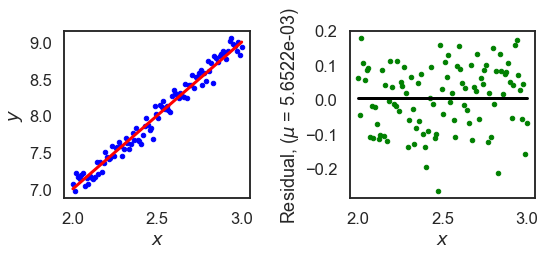

In [37]:
nds = 100
m = 2.0
b = 3.0
x = np.linspace(2, 3, num=nds).reshape(nds, 1)
y = m*x + b + 0.1*np.random.standard_normal(x.shape)
res = y - modelfun(x, [m, b])

sns.set_context('talk')
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(x, y, '.b');
plt.plot(x, modelfun(x, [m, b]), '-r', linewidth = 3);
plt.xlabel('$x$'); plt.ylabel('$y$');
plt.subplot(1,2,2)
plt.plot(x, res, '.g');
mr = res.mean()
plt.plot([x[0], x[-1]], [mr, mr], '-k', linewidth = 3)
plt.xlabel('$x$'); plt.ylabel(s = str('Residual, ($\\mu$ = {:5.4e})'.format(mr)));
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Initialize MCMC Object and Setup Simulation
- In the simulation options, we turn off the waitbar and set the output verbosity to 0.  The results will be saved to a json file.
- We define a directory name based on the date/time to ensure we do not overwrite any results.
- We add the model parameters, but their initial values will actually be determine later.

In [18]:
mcset = MCMC()
# Add data
mcset.data.add_data_set(x, y)
datestr = datetime.now().strftime('%Y%m%d_%H%M%S')
savedir = str('{}_{}'.format(datestr, 'parallel_chains'))
mcset.simulation_options.define_simulation_options(nsimu = int(5.0e3), updatesigma = 1, method = 'dram', 
                                                   savedir = savedir, savesize = 1000, save_to_json = True, 
                                                   verbosity = 0, waitbar = 0)
mcset.model_settings.define_model_settings(sos_function = ssfun)
mcset.parameters.add_model_parameter(name = 'm', theta0 = 2., minimum = -10, maximum = 200, sample = 1)
mcset.parameters.add_model_parameter(name = 'b', theta0 = 2.75, minimum = -10, maximum = 100, sample = 1)

# Setup Parallel Simulation and Define Initial Values
- You can specify the number of chains to be generated (`num_chain`) and the number of cores to use (`num_cores`).
- Note, the initial values are defined in a 3x2 array.  The expected size is [num_chain x num_par], which is 3x2 in this case.  If you don't specify initial values, then a random set will be generated within the parameter space.

In [19]:
# setup parallel MCMC
parMC = ParallelMCMC()
initial_values = np.array([[2.5, 2.5], [1.8, 3.8], [2.05, 3.42]])
parMC.setup_parallel_simulation(mcset = mcset, initial_values = initial_values,
                                num_chain = 3, num_cores = 4)

# Run Parallel Simulation and Display Chain Statistics

In [20]:
parMC.run_parallel_simulation()
parMC.display_individual_chain_statistics()

Processing: 20181105_112319_parallel_chains/chain_0
Processing: 20181105_112319_parallel_chains/chain_1
Processing: 20181105_112319_parallel_chains/chain_2
Parallel simulation run time: 1.3555772304534912 sec

****************************************
Displaying results for chain 0
Files: 20181105_112319_parallel_chains/chain_0

---------------------
name      :       mean        std     MC_err        tau     geweke
m         :     1.9959     0.0431     0.0048    63.3565     0.9669
b         :     2.9979     0.1039     0.0115    62.5688     0.9463
---------------------

****************************************
Displaying results for chain 1
Files: 20181105_112319_parallel_chains/chain_1

---------------------
name      :       mean        std     MC_err        tau     geweke
m         :     1.9897     0.0346     0.0021    13.1104     0.9879
b         :     3.0136     0.0867     0.0053    12.8457     0.9806
---------------------

****************************************
Displaying result

# Processing Chains
For this example I assume that the MCMC simulations were run, then the user went to process the saved results at a later time.  We load the results from the simulation and demonstrate how to plot the parameter distributions and pairwise correlation using the [mcmcplot](https://prmiles.wordpress.ncsu.edu/codes/python-packages/mcmcplot/) package.

To load the results we must specify the name of the top level directory where the parallel results are stored.  We previously defined the `savedir` variable, so it still exists in memory.  If it wasn't, then we would need to define it as the string matching the directory name.

In [21]:
savedir

'20181105_112319_parallel_chains'

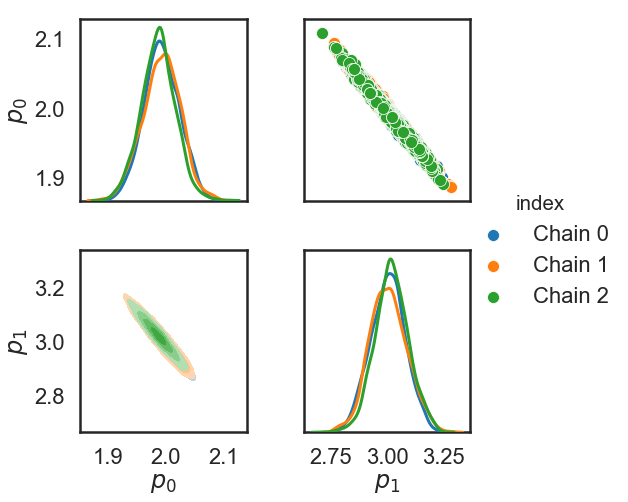

In [22]:
pres = load_parallel_simulation_results(savedir)
combined_chains, index = CP.generate_combined_chain_with_index(pres)

settings = dict(sns = {'axis.grid': True}, pairgrid = dict(height = 3.75, hue = 'index',
                despine = False), ld_type = sns.kdeplot, ld = dict(n_levels = 5, shade = True,
                shade_lowest = False), md = dict(lw = 3))
sns.set_context('poster')
fpg, used_settings = mcsns.plot_paired_density_matrix(chains = combined_chains, sns_style='white',settings = settings, index = index)
fpg.add_legend()
fpg.savefig('parallel_chains.png')

Qualitatively, it appears as though the chains have converged to about the same distribution.

# Gelman-Rubin Diagnostic
In the previous section we generated the list of chains which are required for the Gelman-Rubin diagnostic.  Note, this implementation assumes that all chains have the same dimension.  The output will be a dictionary where the keys are the parameter names.  Each parameter references another dictionary which contains
- `R`, Potential Scale Reduction Factor (PSRF)
- `B`, Between Sequence Variance
- `W`, Within Sequence Variance
- `V`, Mixture-of-Sequences Variance
- `neff`, Effective Number of Samples

In [29]:
chains = CP.generate_chain_list(pres)
psrf = CS.gelman_rubin(chains = chains, display=True);

Parameter: $p_{0}$
  R = 1.0083488934382114
  B = 0.030847335738176624
  W = 0.000958317816586003
  V = 0.0009743864018530628
  neff = 236.90532225944318
Parameter: $p_{1}$
  R = 1.0089344212082867
  B = 0.20832908957344054
  W = 0.0060554181956625625
  V = 0.006164104876156799
  neff = 221.91229590564996


In general, `R` closer to 1 indicates your chains have converged.